In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np


In [2]:
df = pd.read_csv("D:\Project DS Final\Data Preprocessing\data_clean_final.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34847 entries, 0 to 34846
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DAY_OF_MONTH       34847 non-null  int64  
 1   DAY_OF_WEEK        34847 non-null  int64  
 2   OP_UNIQUE_CARRIER  34847 non-null  object 
 3   ORIGIN             34847 non-null  object 
 4   ORIGIN_STATE_ABR   34847 non-null  object 
 5   DEST               34847 non-null  object 
 6   DEST_STATE_ABR     34847 non-null  object 
 7   CRS_DEP_TIME       34847 non-null  float64
 8   CRS_ARR_TIME       34847 non-null  float64
 9   ARR_DELAY          34847 non-null  float64
 10  ARR_DELAY_NEW      34847 non-null  float64
 11  ARR_DEL15          34847 non-null  float64
 12  ARR_DELAY_GROUP    34847 non-null  float64
 13  CRS_ELAPSED_TIME   34847 non-null  int64  
 14  DISTANCE           34847 non-null  int64  
 15  DISTANCE_GROUP     34847 non-null  int64  
 16  ORIGIN-DEST        348

### Theo tuyến bay (Route-specific patterns)

In [5]:
# Nhóm theo tuyến bay và tính thống kê
route_delay_stats = (
    df.groupby("ORIGIN-DEST")
    .agg(
        NUM_FLIGHTS=("ARR_DELAY", "count"),           # tổng số chuyến
        AVG_ARR_DELAY=("ARR_DELAY", "mean"),          # delay trung bình (phút)
        PCT_DELAYED_15=("ARR_DEL15", "mean"),         # tỷ lệ chuyến trễ >15 phút
        NUM_DELAYED=("ARR_DEL15", "sum")              # số chuyến trễ >15 phút
    )
    .reset_index()
)

# Lấy top 10 tuyến bay có nhiều chuyến nhất
top10_routes = route_delay_stats.sort_values(by="NUM_FLIGHTS", ascending=False).head(10)
print(top10_routes)

    ORIGIN-DEST  NUM_FLIGHTS  AVG_ARR_DELAY  PCT_DELAYED_15  NUM_DELAYED
138     SEA-ANC          696      11.932471        0.333333        232.0
1       ANC-SEA          695       1.559712        0.174101        121.0
32      DEN-SEA          636      26.514151        0.399371        254.0
155     SEA-DEN          629      20.519873        0.348172        219.0
176     SEA-LAX          629       3.731320        0.197138        124.0
221     SFO-SEA          627      11.738437        0.341308        214.0
81      LAX-SEA          626       5.068690        0.228435        143.0
209     SEA-SFO          626       8.241214        0.281150        176.0
115     PHX-SEA          616       3.961039        0.228896        141.0
197     SEA-PHX          615       6.377236        0.237398        146.0


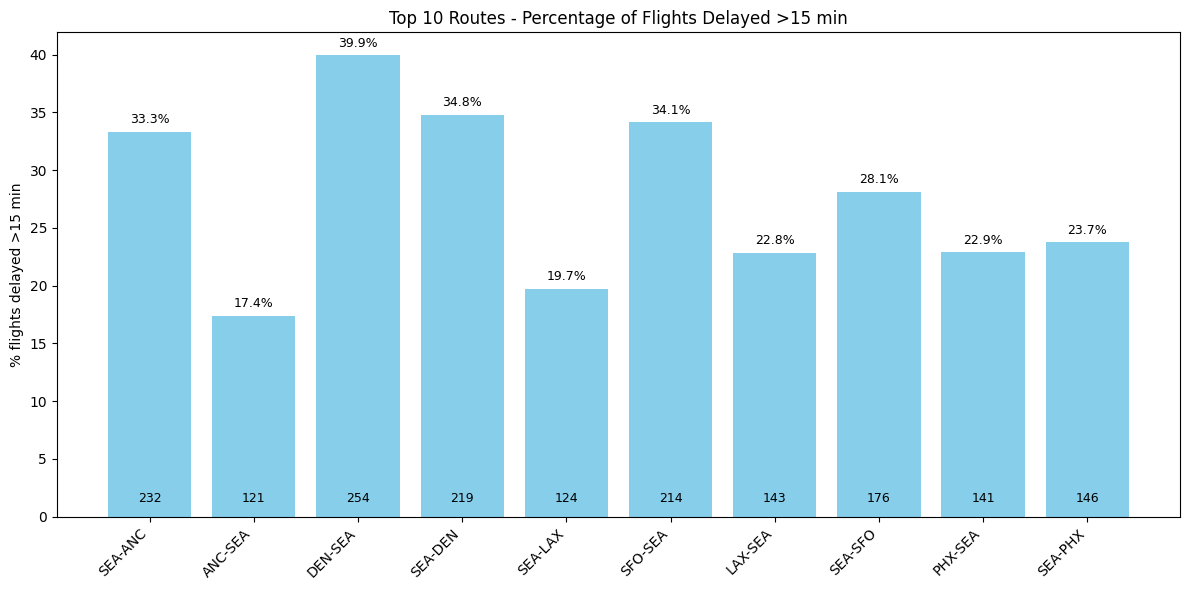

In [6]:
# ========== 1. % DELAYED > 15 phút ==========
plt.figure(figsize=(12,6))
bars = plt.bar(top10_routes["ORIGIN-DEST"], top10_routes["PCT_DELAYED_15"]*100, color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("% flights delayed >15 min")
plt.title("Top 10 Routes - Percentage of Flights Delayed >15 min")

# Annotate trên đầu cột: % delay
for bar, pct in zip(bars, top10_routes["PCT_DELAYED_15"]*100):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.5,
             f"{pct:.1f}%", ha="center", va="bottom", fontsize=9)

# Annotate trong chân cột: số chuyến bị delay
for bar, n in zip(bars, top10_routes["NUM_DELAYED"]):
    plt.text(bar.get_x() + bar.get_width()/2, 1,   # đặt ở gần chân cột
             f"{int(n)}", ha="center", va="bottom", fontsize=9, color="black")

plt.tight_layout()
plt.show()

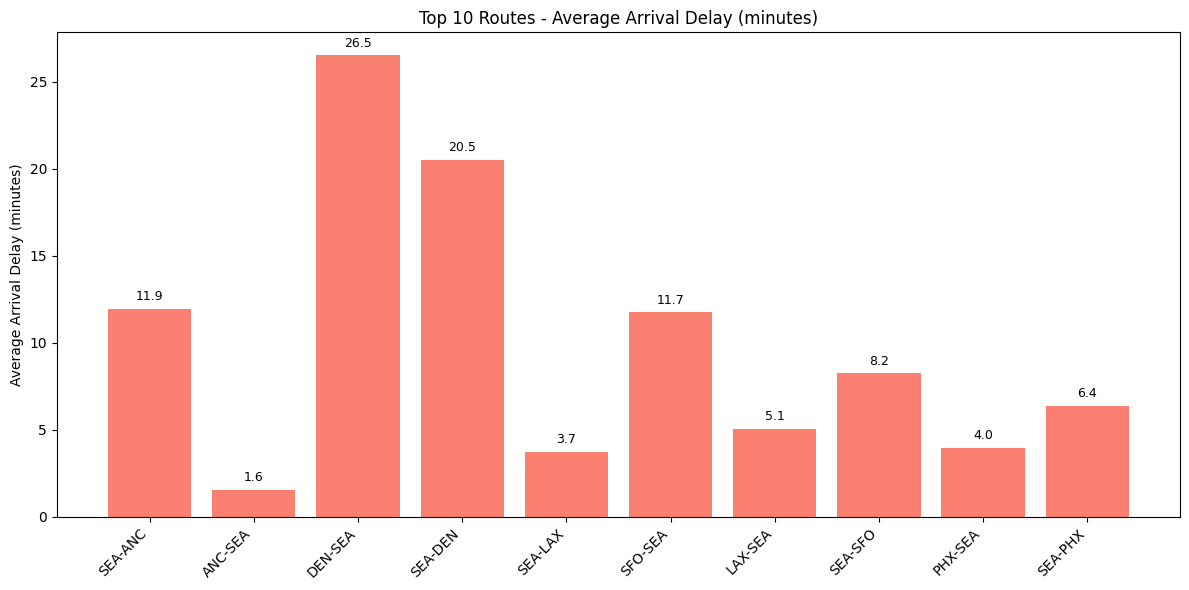

In [7]:
# ========== 2. Delay trung bình ==========
plt.figure(figsize=(12,6))
plt.bar(top10_routes["ORIGIN-DEST"], top10_routes["AVG_ARR_DELAY"], color="salmon")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average Arrival Delay (minutes)")
plt.title("Top 10 Routes - Average Arrival Delay (minutes)")
for i, v in enumerate(top10_routes["AVG_ARR_DELAY"]):
    plt.text(i, v+0.5, f"{v:.1f}", ha="center", fontsize=9)
plt.tight_layout()
plt.show()

### Theo khung giờ (Time-of-day effect)

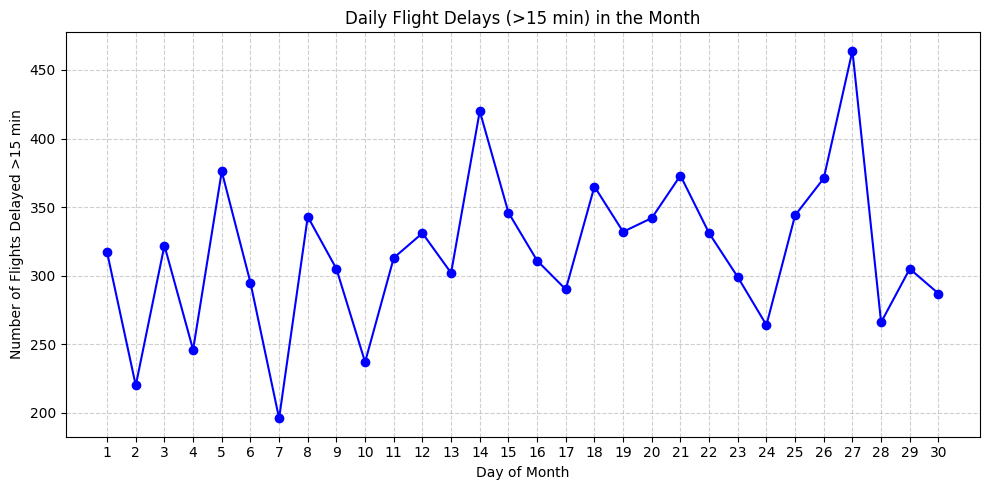

In [8]:
# Tính số chuyến bị delay >15 phút theo ngày
daily_delays = (
    df.groupby("DAY_OF_MONTH")["ARR_DEL15"]
    .sum()
    .reset_index()
)

# Vẽ line chart
plt.figure(figsize=(10,5))
plt.plot(daily_delays["DAY_OF_MONTH"], daily_delays["ARR_DEL15"], marker="o", linestyle="-", color="blue")
plt.xticks(range(1, daily_delays["DAY_OF_MONTH"].max()+1))
plt.xlabel("Day of Month")
plt.ylabel("Number of Flights Delayed >15 min")
plt.title("Daily Flight Delays (>15 min) in the Month")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

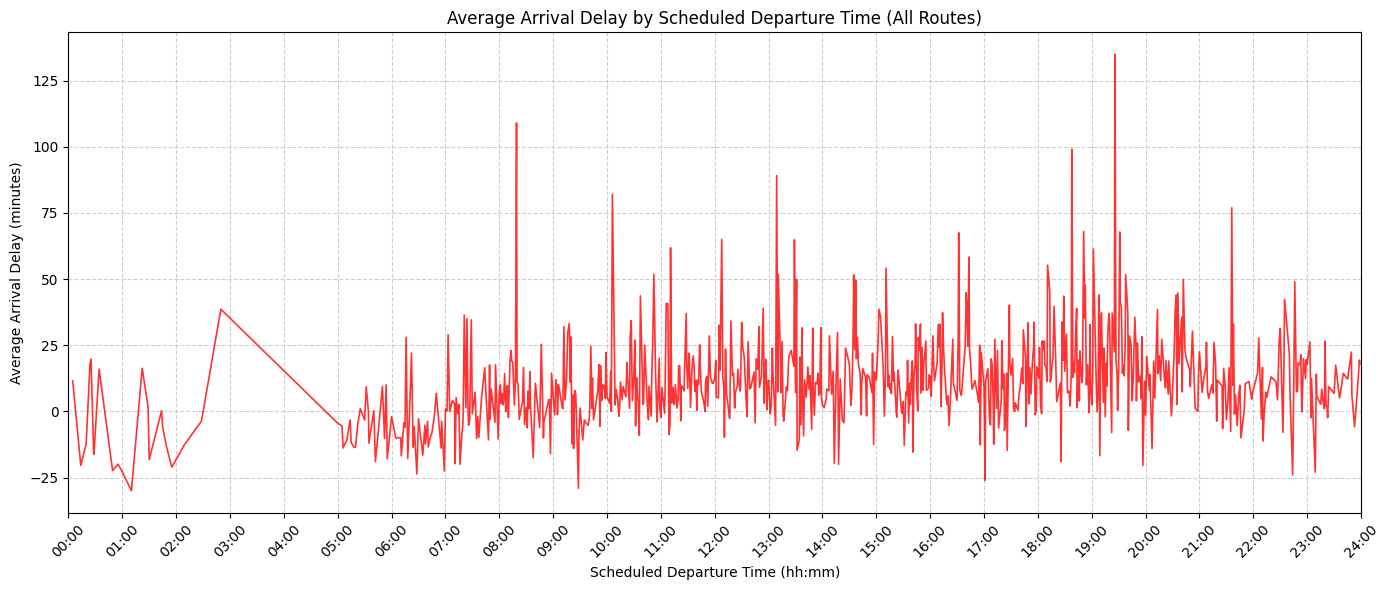

In [9]:
# Hàm chuyển float (giờ thập phân) -> hh:mm
def float_to_hhmm(x):
    hour = int(x)
    minute = int(round((x - hour)*60))
    if minute == 60:   # xử lý khi round ra 60 phút
        hour += 1
        minute = 0
    return f"{hour:02d}:{minute:02d}"

# Lấy giờ khởi hành (float)
df["DEP_HOUR_MIN"] = df["CRS_DEP_TIME"].astype(float)

# Nhóm theo giờ khởi hành, tính ARR_DELAY trung bình
time_delays = df.groupby("DEP_HOUR_MIN")["ARR_DELAY"].mean().reset_index()

# Vẽ line chart
plt.figure(figsize=(14,6))
plt.plot(
    time_delays["DEP_HOUR_MIN"], 
    time_delays["ARR_DELAY"], 
    color="red", 
    linewidth=1.2,   # line mảnh hơn
    alpha=0.8        # làm nhạt line
)

# Trục X từ 0h–24h
x_ticks = np.arange(0,25,1)
plt.xticks(x_ticks, [float_to_hhmm(x) for x in x_ticks], rotation=45)

plt.xlim(0,24)
plt.xlabel("Scheduled Departure Time (hh:mm)")
plt.ylabel("Average Arrival Delay (minutes)")
plt.title("Average Arrival Delay by Scheduled Departure Time (All Routes)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


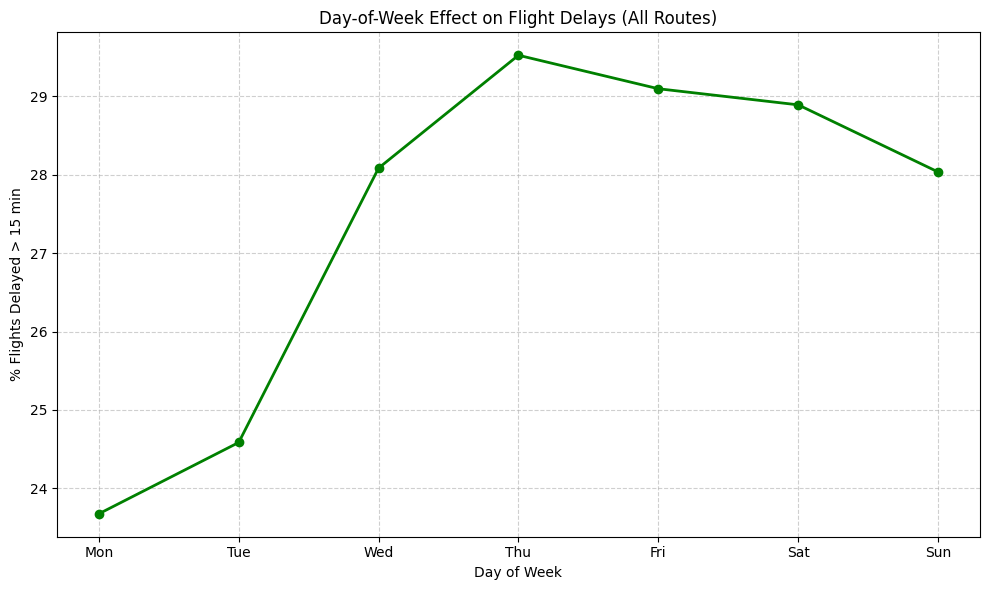

In [10]:
# Map số -> tên ngày
day_map = {1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat", 7:"Sun"}
df["DAY_NAME"] = df["DAY_OF_WEEK"].map(day_map)

# Tính % chuyến delay >15 phút theo ngày trong tuần
dow_delays = (
    df.groupby("DAY_NAME")["ARR_DEL15"].mean()
    .reindex(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
    .reset_index()
)

# Vẽ line chart
plt.figure(figsize=(10,6))
plt.plot(dow_delays["DAY_NAME"], dow_delays["ARR_DEL15"]*100,
         marker="o", color="green", linewidth=2)

plt.xlabel("Day of Week")
plt.ylabel("% Flights Delayed > 15 min")
plt.title("Day-of-Week Effect on Flight Delays (All Routes)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


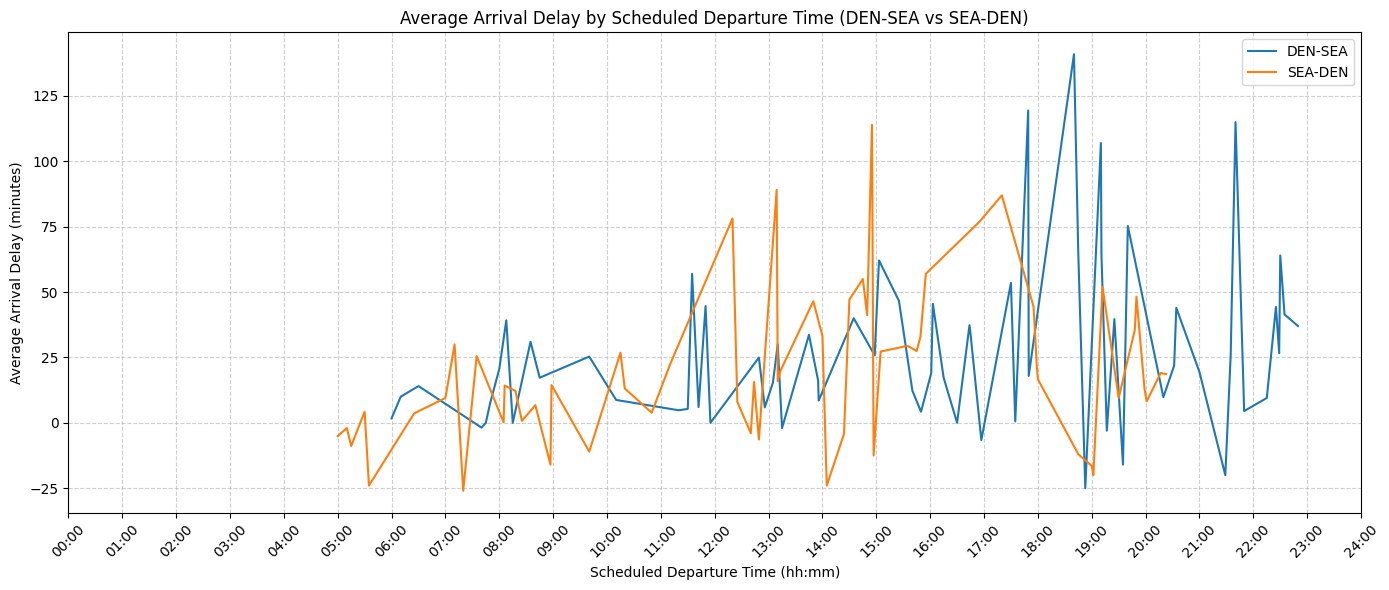

In [11]:
# -------------------------------
# Average Arrival Delay theo Scheduled Departure Time (DEN-SEA vs SEA-DEN)
# -------------------------------

routes = ["DEN-SEA", "SEA-DEN"]

plt.figure(figsize=(14,6))
for route in routes:
    temp = df[df["ORIGIN-DEST"] == route].copy()
    temp["DEP_HOUR_MIN"] = temp["CRS_DEP_TIME"].astype(float)
    
    # Tính delay trung bình theo giờ khởi hành
    hourly = temp.groupby("DEP_HOUR_MIN")["ARR_DELAY"].mean().reset_index()
    
    # Vẽ line chart
    plt.plot(hourly["DEP_HOUR_MIN"], hourly["ARR_DELAY"], 
             linewidth=1.5, label=route)

# Trục X từ 0h–24h
x_ticks = np.arange(0,25,1)
plt.xticks(x_ticks, [float_to_hhmm(x) for x in x_ticks], rotation=45)

plt.xlim(0,24)
plt.xlabel("Scheduled Departure Time (hh:mm)")
plt.ylabel("Average Arrival Delay (minutes)")
plt.title("Average Arrival Delay by Scheduled Departure Time (DEN-SEA vs SEA-DEN)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


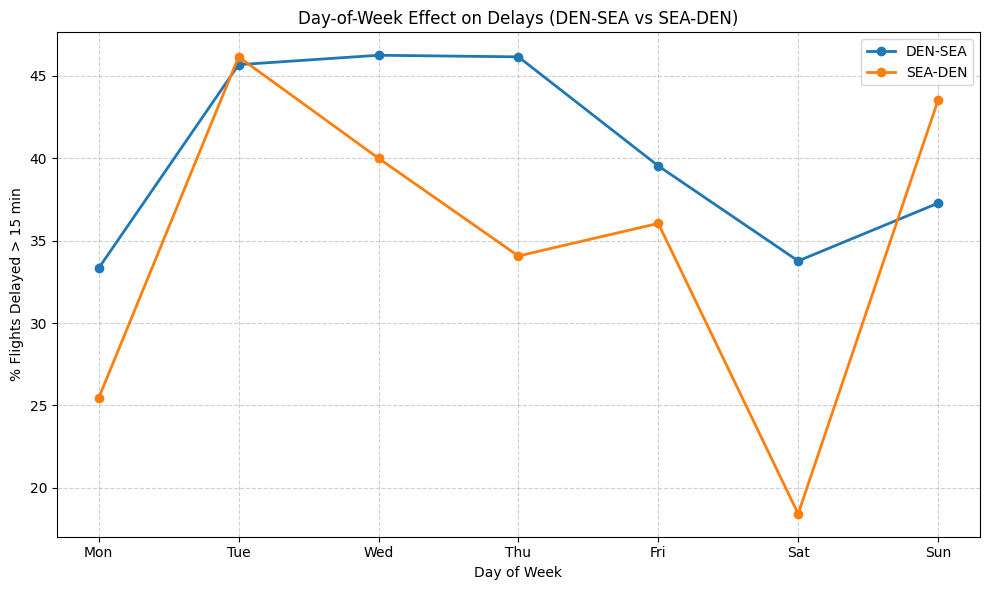

In [12]:
# -------------------------------
# Day-of-week effect: DEN-SEA vs SEA-DEN
# -------------------------------
plt.figure(figsize=(10,6))
for route in routes:
    temp = df[df["ORIGIN-DEST"] == route].copy()
    dow = (
        temp.groupby("DAY_NAME")["ARR_DEL15"].mean()
        .reindex(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
        .reset_index()
    )
    plt.plot(dow["DAY_NAME"], dow["ARR_DEL15"]*100,
             marker="o", linewidth=2, label=route)

plt.xlabel("Day of Week")
plt.ylabel("% Flights Delayed > 15 min")
plt.title("Day-of-Week Effect on Delays (DEN-SEA vs SEA-DEN)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### Theo hãng bay (Carrier performance)

In [13]:
df["OP_UNIQUE_CARRIER"].unique()

array(['AA', 'AS', 'B6', 'DL', 'F9', 'G4', 'HA', 'NK', 'OO', 'UA', 'WN',
       'MQ'], dtype=object)

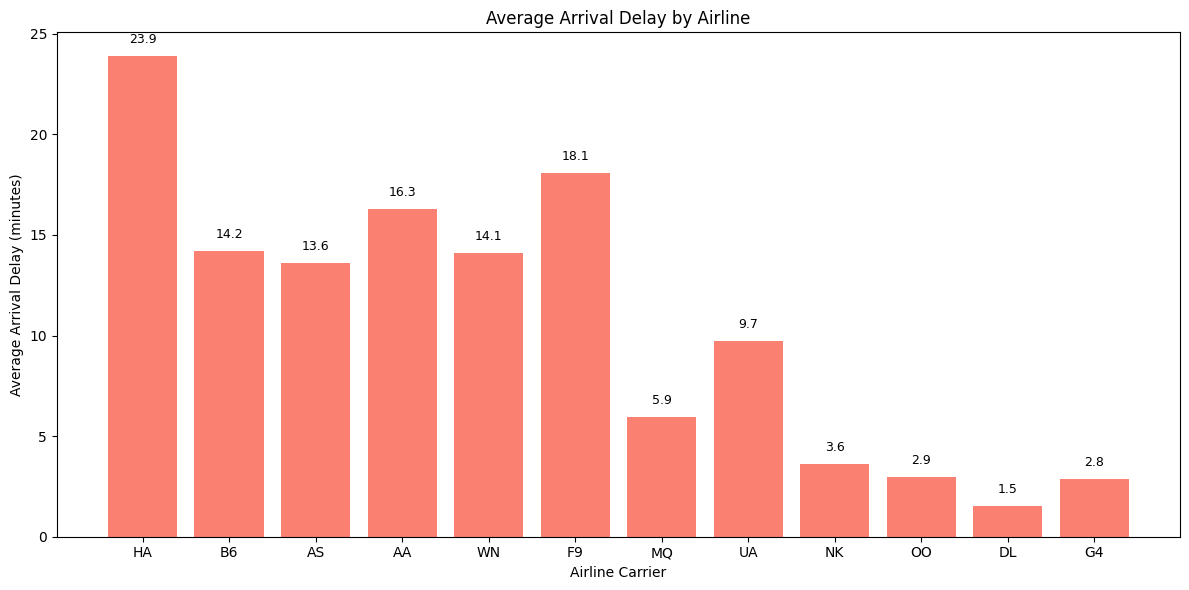

In [14]:
# ---- Tính toán theo hãng ----
carrier_stats = df.groupby("OP_UNIQUE_CARRIER").agg(
    NUM_FLIGHTS=("ARR_DEL15", "count"),
    PCT_DELAYED_15=("ARR_DEL15", "mean"),
    AVG_ARR_DELAY=("ARR_DELAY", "mean")
).reset_index()

# ---- Sắp xếp theo % delay ----
carrier_stats = carrier_stats.sort_values("PCT_DELAYED_15", ascending=False)

# ---- Chart 2: Average Arrival Delay (minutes) ----
plt.figure(figsize=(12,6))
bars = plt.bar(carrier_stats["OP_UNIQUE_CARRIER"], carrier_stats["AVG_ARR_DELAY"], color="salmon")

# Ghi giá trị delay trung bình lên trên cột
for bar, delay in zip(bars, carrier_stats["AVG_ARR_DELAY"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.5,
             f"{delay:.1f}", ha="center", va="bottom", fontsize=9)

plt.xlabel("Airline Carrier")
plt.ylabel("Average Arrival Delay (minutes)")
plt.title("Average Arrival Delay by Airline")
plt.tight_layout()
plt.show()


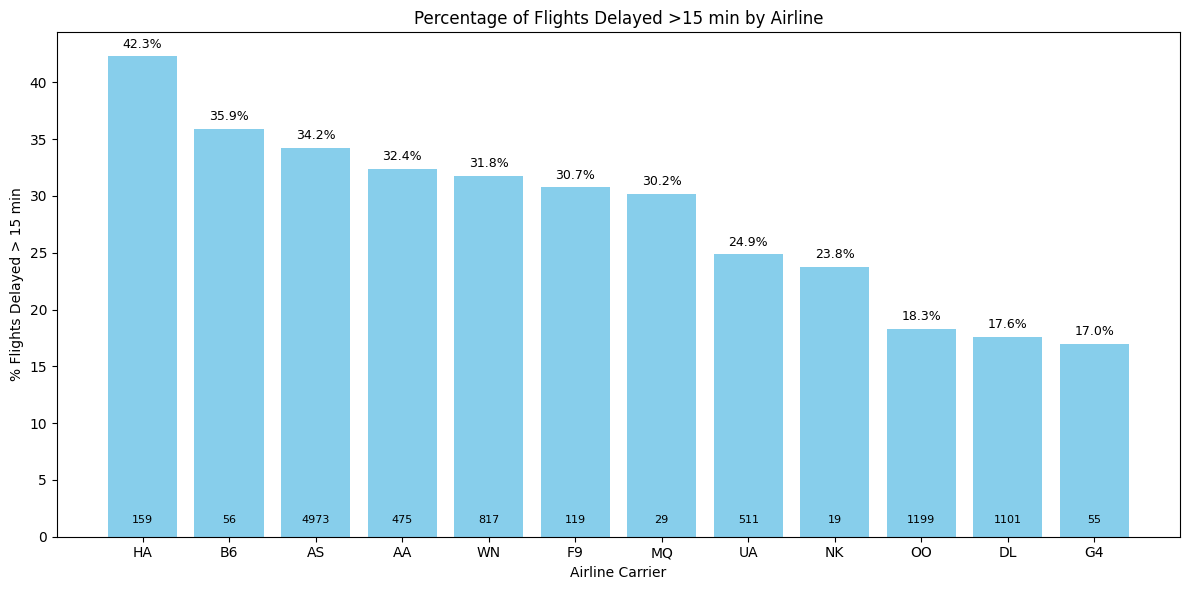

In [15]:
# ---- Tính toán theo hãng ----
carrier_stats = df.groupby("OP_UNIQUE_CARRIER").agg(
    NUM_FLIGHTS=("ARR_DEL15", "count"),
    NUM_DELAYED=("ARR_DEL15", "sum"),     # số chuyến delay >15 phút
    PCT_DELAYED_15=("ARR_DEL15", "mean")
).reset_index()

# ---- Sắp xếp theo % delay ----
carrier_stats = carrier_stats.sort_values("PCT_DELAYED_15", ascending=False)

# ---- Vẽ bar chart ----
plt.figure(figsize=(12,6))
bars = plt.bar(carrier_stats["OP_UNIQUE_CARRIER"], 
               carrier_stats["PCT_DELAYED_15"]*100, 
               color="skyblue")

# Ghi % delay trên đỉnh cột
for bar, pct in zip(bars, carrier_stats["PCT_DELAYED_15"]*100):
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height()+0.5,
             f"{pct:.1f}%", ha="center", va="bottom", fontsize=9, color="black")

# Ghi số chuyến ngay trong chân cột
for bar, n in zip(bars, carrier_stats["NUM_DELAYED"]):
    plt.text(bar.get_x() + bar.get_width()/2, 
             1,   # vị trí gần chân cột (sát trục X)
             f"{int(n)}", ha="center", va="bottom", fontsize=8, color="black")

plt.xlabel("Airline Carrier")
plt.ylabel("% Flights Delayed > 15 min")
plt.title("Percentage of Flights Delayed >15 min by Airline")
plt.tight_layout()
plt.show()



### Theo khoảng cách

##### Not recommended tại chart xấu quá. Không thể hiện rõ distance xa thì delay lâu với nhiều hơn 

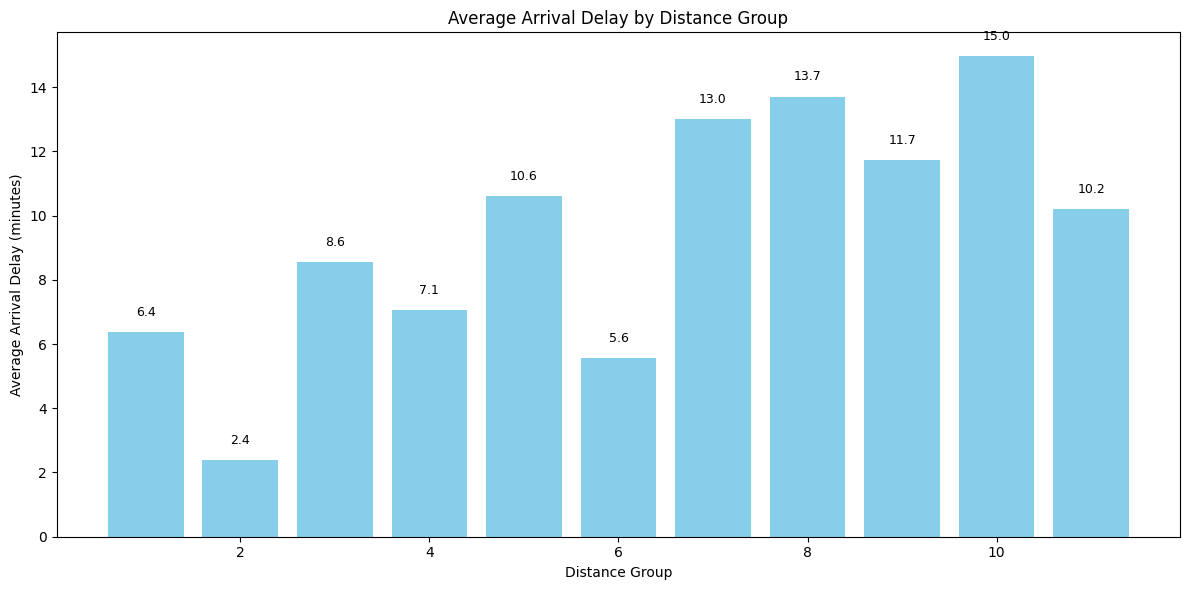

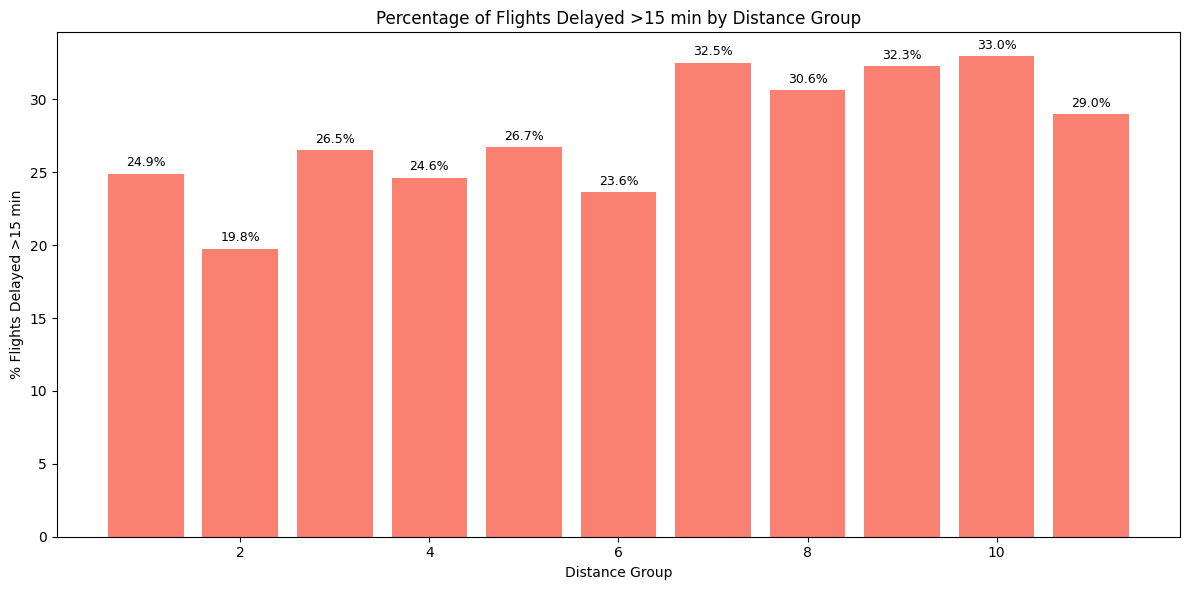

In [16]:
# --- Trung bình delay theo distance group ---
dist_stats = (
    df.groupby("DISTANCE_GROUP")
    .agg(
        AVG_ARR_DELAY=("ARR_DELAY", "mean"),
        PCT_DELAYED_15=("ARR_DEL15", "mean"),
        NUM_FLIGHTS=("ARR_DELAY", "count")
    )
    .reset_index()
)

# --- Bar chart: Delay trung bình ---
plt.figure(figsize=(12,6))
bars = plt.bar(dist_stats["DISTANCE_GROUP"], dist_stats["AVG_ARR_DELAY"], color="skyblue")

# Ghi giá trị lên cột
for bar, val in zip(bars, dist_stats["AVG_ARR_DELAY"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.5,
             f"{val:.1f}", ha="center", fontsize=9)

plt.xlabel("Distance Group")
plt.ylabel("Average Arrival Delay (minutes)")
plt.title("Average Arrival Delay by Distance Group")
plt.tight_layout()
plt.show()


# --- Bar chart: % chuyến delay >15 phút ---
plt.figure(figsize=(12,6))
bars = plt.bar(dist_stats["DISTANCE_GROUP"], dist_stats["PCT_DELAYED_15"]*100, color="salmon")

for bar, val in zip(bars, dist_stats["PCT_DELAYED_15"]*100):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.5,
             f"{val:.1f}%", ha="center", fontsize=9)

plt.xlabel("Distance Group")
plt.ylabel("% Flights Delayed >15 min")
plt.title("Percentage of Flights Delayed >15 min by Distance Group")
plt.tight_layout()
plt.show()


